# EBS simulation

## Note and explanations

## imports

In [33]:
import datetime
import math
import os
import random
import time

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from scipy.optimize import OptimizeResult, brute, minimize, minimize_scalar
from tqdm.notebook import tqdm
from decouple import AutoConfig
from pathlib import Path
from math import ceil

from src.utils.profiles import generate_dep_Pax_Counters, show_up_function
from src.utils.profiles_from_schedule import (
    generate_dep_Pax_Counters as custom_generate_dep_Pax_Counters,
)

from src.simfunc.KIX_T1d import KIX_T1d, univariate_cost_function_generator_T1d_N
from src.simfunc.KIX_T1d_CUSBD import (
    KIX_T1d_CUSBD,
    univariate_cost_function_generator_T1d_CUSBD_N,
)

from src.utils.optimizers import custcallback, custmin
from src.utils.helpers import calculate_EBS_LBC, calculate_avg_dwell_time,calculate_EBS_modern_pax_only

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

%load_ext autoreload
%autoreload 2

%load_ext nb_black

<IPython.core.display.Javascript object>

## Calculations

### parameters import

In [3]:
# get the paths to config
root_path = Path(os.getcwd()) / "../../"
DOTENV_FILE_PATH = root_path / "data/secret/.env"
config = AutoConfig(search_path=DOTENV_FILE_PATH)
path_param = root_path / config("ADRM_param_full_path")

<IPython.core.display.Javascript object>

In [4]:
df_param_onedrive = pd.read_excel(
    path_param,
    sheet_name="Dynamic",
)

# generate df_set_param_T1d_from_drive from one drive excel file (assumptions all dept)
df_param_input = df_param_onedrive.set_index("item", drop=True, inplace=False)

# keep only T1 Int'l dep results
mask_T1d = (df_param_input["terminal"] == "T1") & (df_param_input["Direction"] == "D")
df_param_input_T1 = df_param_input[mask_T1d]

df_param_input_T1 = df_param_input_T1.drop(
    columns=["unit", "terminal", "type", "remarks", "Direction"]
)

# take values from assumption files and put them in a dictionnary
list_item = [
    "target_peak_STD",
    "Pt_checkin_1step_counter",
    "Pt_checkin_2step_counter",
    "N_kiosk",
    "Pt_kiosk",
    "N_security_lanes",
    "Pt_security_lanes",
    "N_emigration_counter",
    "Pt_emigration_counter",
    "N_emigration_self",
    "Pt_emigration_self",
    "modern_pax_ratio",
    "digital_pax_ratio",
    "premium_pax_ratio",
    "start_special_pax_ratio",
    "end_special_pax_ratio",
]

dct_set_param_T1d_from_drive = {
    item: list(df_param_input_T1.loc[item, :]) for item in list_item
}
len_dct_set_param_T1d_from_drive = len(dct_set_param_T1d_from_drive["target_peak_STD"])
dct_set_param_T1d_from_drive["target_peak"] = dct_set_param_T1d_from_drive.pop(
    "target_peak_STD"
)

# define values that are not in assumption files
dct_set_param_T1d_from_drive["freq"] = [
    "1min" for i in range(len_dct_set_param_T1d_from_drive)
]
dct_set_param_T1d_from_drive["win"] = [
    15 for i in range(len_dct_set_param_T1d_from_drive)
]
dct_set_param_T1d_from_drive["show_loading"] = [
    True for i in range(len_dct_set_param_T1d_from_drive)
]
dct_set_param_T1d_from_drive["show_graph"] = [
    False for i in range(len_dct_set_param_T1d_from_drive)
]
dct_set_param_T1d_from_drive["save_graph"] = [
    False for i in range(len_dct_set_param_T1d_from_drive)
]
dct_set_param_T1d_from_drive["save_xls"] = [
    False for i in range(len_dct_set_param_T1d_from_drive)
]

# change the start & end special pax, it was a bad idea
dct_set_param_T1d_from_drive["start_special_pax_ratio"] = [
    0 for i in range(len_dct_set_param_T1d_from_drive)
]

dct_set_param_T1d_from_drive["end_special_pax_ratio"] = [
    1 for i in range(len_dct_set_param_T1d_from_drive)
]

df_set_param_T1d_from_drive = pd.DataFrame.from_dict(dct_set_param_T1d_from_drive)

df_set_param_T1d = df_set_param_T1d_from_drive.copy()
dct_set_param_T1d = dct_set_param_T1d_from_drive.copy()

# create the dictionary of param for the run from the dct_set_param
# we take the values for 2025
dct_run_param = {keys: value[5] for keys, value in dct_set_param_T1d.items()}

<IPython.core.display.Javascript object>

### CUSBD

In [5]:
# calculate df_Pax
df_Pax_2025, _ = generate_dep_Pax_Counters(
    target_peak=3880,  # for quick test, real FY2025 value is 3880
    terminal="T1",
    custom_counter_rule=False,  # current allocation rule
)

Pax and counter generation...: 100%|██████████| 2/2 [00:08<00:00,  4.09s/it]


<IPython.core.display.Javascript object>

In [6]:
# initialize dct_run_param
dct_run_param_T1d_2025 = dct_run_param.copy()

dct_run_param_T1d_2025["df_Pax"] = df_Pax_2025
dct_run_param_T1d_2025["N_kiosk"] = 99999
dct_run_param_T1d_2025["digital_pax_ratio"] = 0
dct_run_param_T1d_2025["N_CUSBD"] = 24

dct_run_param_T1d_2025["path"] = None
dct_run_param_T1d_2025.pop("target_peak")

4830.409661314034

<IPython.core.display.Javascript object>

In [7]:
from src.simfunc.KIX_T1d_CUSBD import (
    cost_function_T1d_CUSBD_2var_modern_pax_ratio_CUSBD_opening_duration as cost_2_var,
)

<IPython.core.display.Javascript object>

In [8]:
def cost_generator(x):
    cost = cost_2_var(
        x=x,  # ['CUSBD_opening_duration' in minutes,'modern_pax_ratio']
        EBS_capacity=800,  # cost target
        target_wait_time=5,  # target waiting time in minutes
        dct_param_T1d=dct_run_param_T1d_2025,  # includes df_Pax
        target_peak=3880,  # to select good schedule when generating df_Counters
        custom_counter_rule=False,  # to generate df_Counters
        call_n_iter=None,
        totalpbar=None,
    )
    return cost

<IPython.core.display.Javascript object>

### successive grid optimization

In [9]:
# initialize parallel module
import ray

/home/ubuntu/miniconda3/envs/KAPpaxsim2/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  warnings.warn(


<IPython.core.display.Javascript object>

In [10]:
ray.shutdown()
ray.init()

2021-07-11 13:12:06,464	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '172.31.28.92',
 'raylet_ip_address': '172.31.28.92',
 'redis_address': '172.31.28.92:6379',
 'object_store_address': '/tmp/ray/session_2021-07-11_13-12-05_443732_3446/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-07-11_13-12-05_443732_3446/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-07-11_13-12-05_443732_3446',
 'metrics_export_port': 64305,
 'node_id': '28745a0ffe62f100969f1082a7dd1b8bb2ca2d00d04d1ac333db09bc'}

<IPython.core.display.Javascript object>

In [11]:
# x is CUSBD_open_time
xmin = 250
xmax = 360
N_fev_x = 7

# y is CUSBD_ratio
ymin = 0.1
ymax = 0.99
N_fev_y = 6

# number of successive grid_search
N_grid_search = 2

# parameter ray for parallel computing
@ray.remote
def f(x):
    return cost_generator(x)


# create dct of results
dct_grid_search = {}

<IPython.core.display.Javascript object>

In [12]:
for n in range(N_grid_search):
    # build grid_list
    x_range = list(np.linspace(xmin, xmax, N_fev_x))
    y_range = list(np.linspace(ymin, ymax, N_fev_y))
    grid_list = [(x, y) for y in y_range for x in x_range]

    # evaluate all points of the grid in parallel
    futures = [f.remote(i) for i in grid_list]
    results = ray.get(futures)

    # get the best point
    bestz = min(results)
    index = results.index(bestz)
    best_point = grid_list[index]
    bestx = best_point[0]
    besty = best_point[1]

    # build new ranges for next iteration's grid_list
    # new range on x
    if bestx != xmin:
        xmin = x_range[x_range.index(bestx) - 1]
    if bestx != xmax:
        xmax = x_range[x_range.index(bestx) + 1]

    # new range on y
    if besty != ymin:
        ymin = y_range[y_range.index(besty) - 1]
    if besty != ymax:
        ymax = y_range[y_range.index(besty) + 1]

    # store grid search results
    dct_grid_search[n] = [grid_list, results]

 | 1287/1440 [06:06<00:16,  9.36it/s]
Simulation running...: 100%|██████████| 1440/1440 [06:15<00:00,  3.84it/s] 


<IPython.core.display.Javascript object>

In [13]:
# display result
bestx, besty, bestz

(323.3333333333333, 0.49160000000000004, 102.009336111111)

<IPython.core.display.Javascript object>

In [14]:
# put results in a DataFrame
list_x = []
list_y = []
list_z = []
list_N_grid = []
for n in dct_grid_search.keys():
    list_x.extend([i[0] for i in dct_grid_search[n][0]])
    list_y.extend([i[1] for i in dct_grid_search[n][0]])
    list_z.extend([i for i in dct_grid_search[n][1]])
    list_N_grid.extend([n for i in dct_grid_search[n][0]])

df_grid_search_results = pd.DataFrame(
    [list_x, list_y, list_z, list_N_grid], index=["x", "y", "z", "N_grid"]
).T

<IPython.core.display.Javascript object>

### plotly grid search vizualisation

In [15]:
import plotly.express as px

fig = px.scatter_3d(df_grid_search_results, x="x", y="y", z="z", color="N_grid")
fig.show()

<IPython.core.display.Javascript object>

## simulate the optimized result

In [21]:
dct_run_param_T1d_2025["modern_pax_ratio"] = besty
dct_run_param_T1d_2025['CUSBD_opening_duration'] = bestx
dct_run_param_T1d_2025['show_graph']=True

<IPython.core.display.Javascript object>

In [27]:
# counter generation
two_step_ratio = (
    dct_run_param_T1d_2025["modern_pax_ratio"] + dct_run_param_T1d_2025["digital_pax_ratio"]
)

# allocation rule depending on modern_pax_ratio
kwargs_rule = {
    "start_time": 3.5,
    "onecounter_time": 0.75,
    "base_n_counter": ceil(3 * (1 - two_step_ratio)),
    "seats_per_add_counter": ceil(110 / (1 - two_step_ratio)),
}

# generate df_Counter (only)
df_Counters = show_up_function(
    target_peak=3880,
    direction="D",
    system="check-in",
    ratio=1,
    terminal="T1",
    CTG_type="A",
    custom_showup=False,
    custom_counter_rule=True,
    **kwargs_rule,
)

dct_run_param_T1d_2025["df_Counters"] = df_Counters

<IPython.core.display.Javascript object>

Simulation running...: 100%|██████████| 1440/1440 [02:34<00:00,  9.35it/s] 
   path  Pt_checkin_1step_counter  Pt_checkin_2step_counter  N_kiosk  \
0  None                  1.603333                      1.27    99999   

   Pt_kiosk  N_CUSBD  CUSBD_opening_duration  N_security_lanes  \
0       1.5       24              323.333333              22.0   

   Pt_security_lanes  N_emigration_counter  ...  premium_pax_ratio  \
0           0.233333                  26.0  ...               0.05   

   start_special_pax_ratio  end_special_pax_ratio  freq  win  show_loading  \
0                        0                      1  1min   15          True   

   show_graph  save_graph save_xls  call_n_iter  
0        True       False    False         None  

[1 rows x 25 columns]


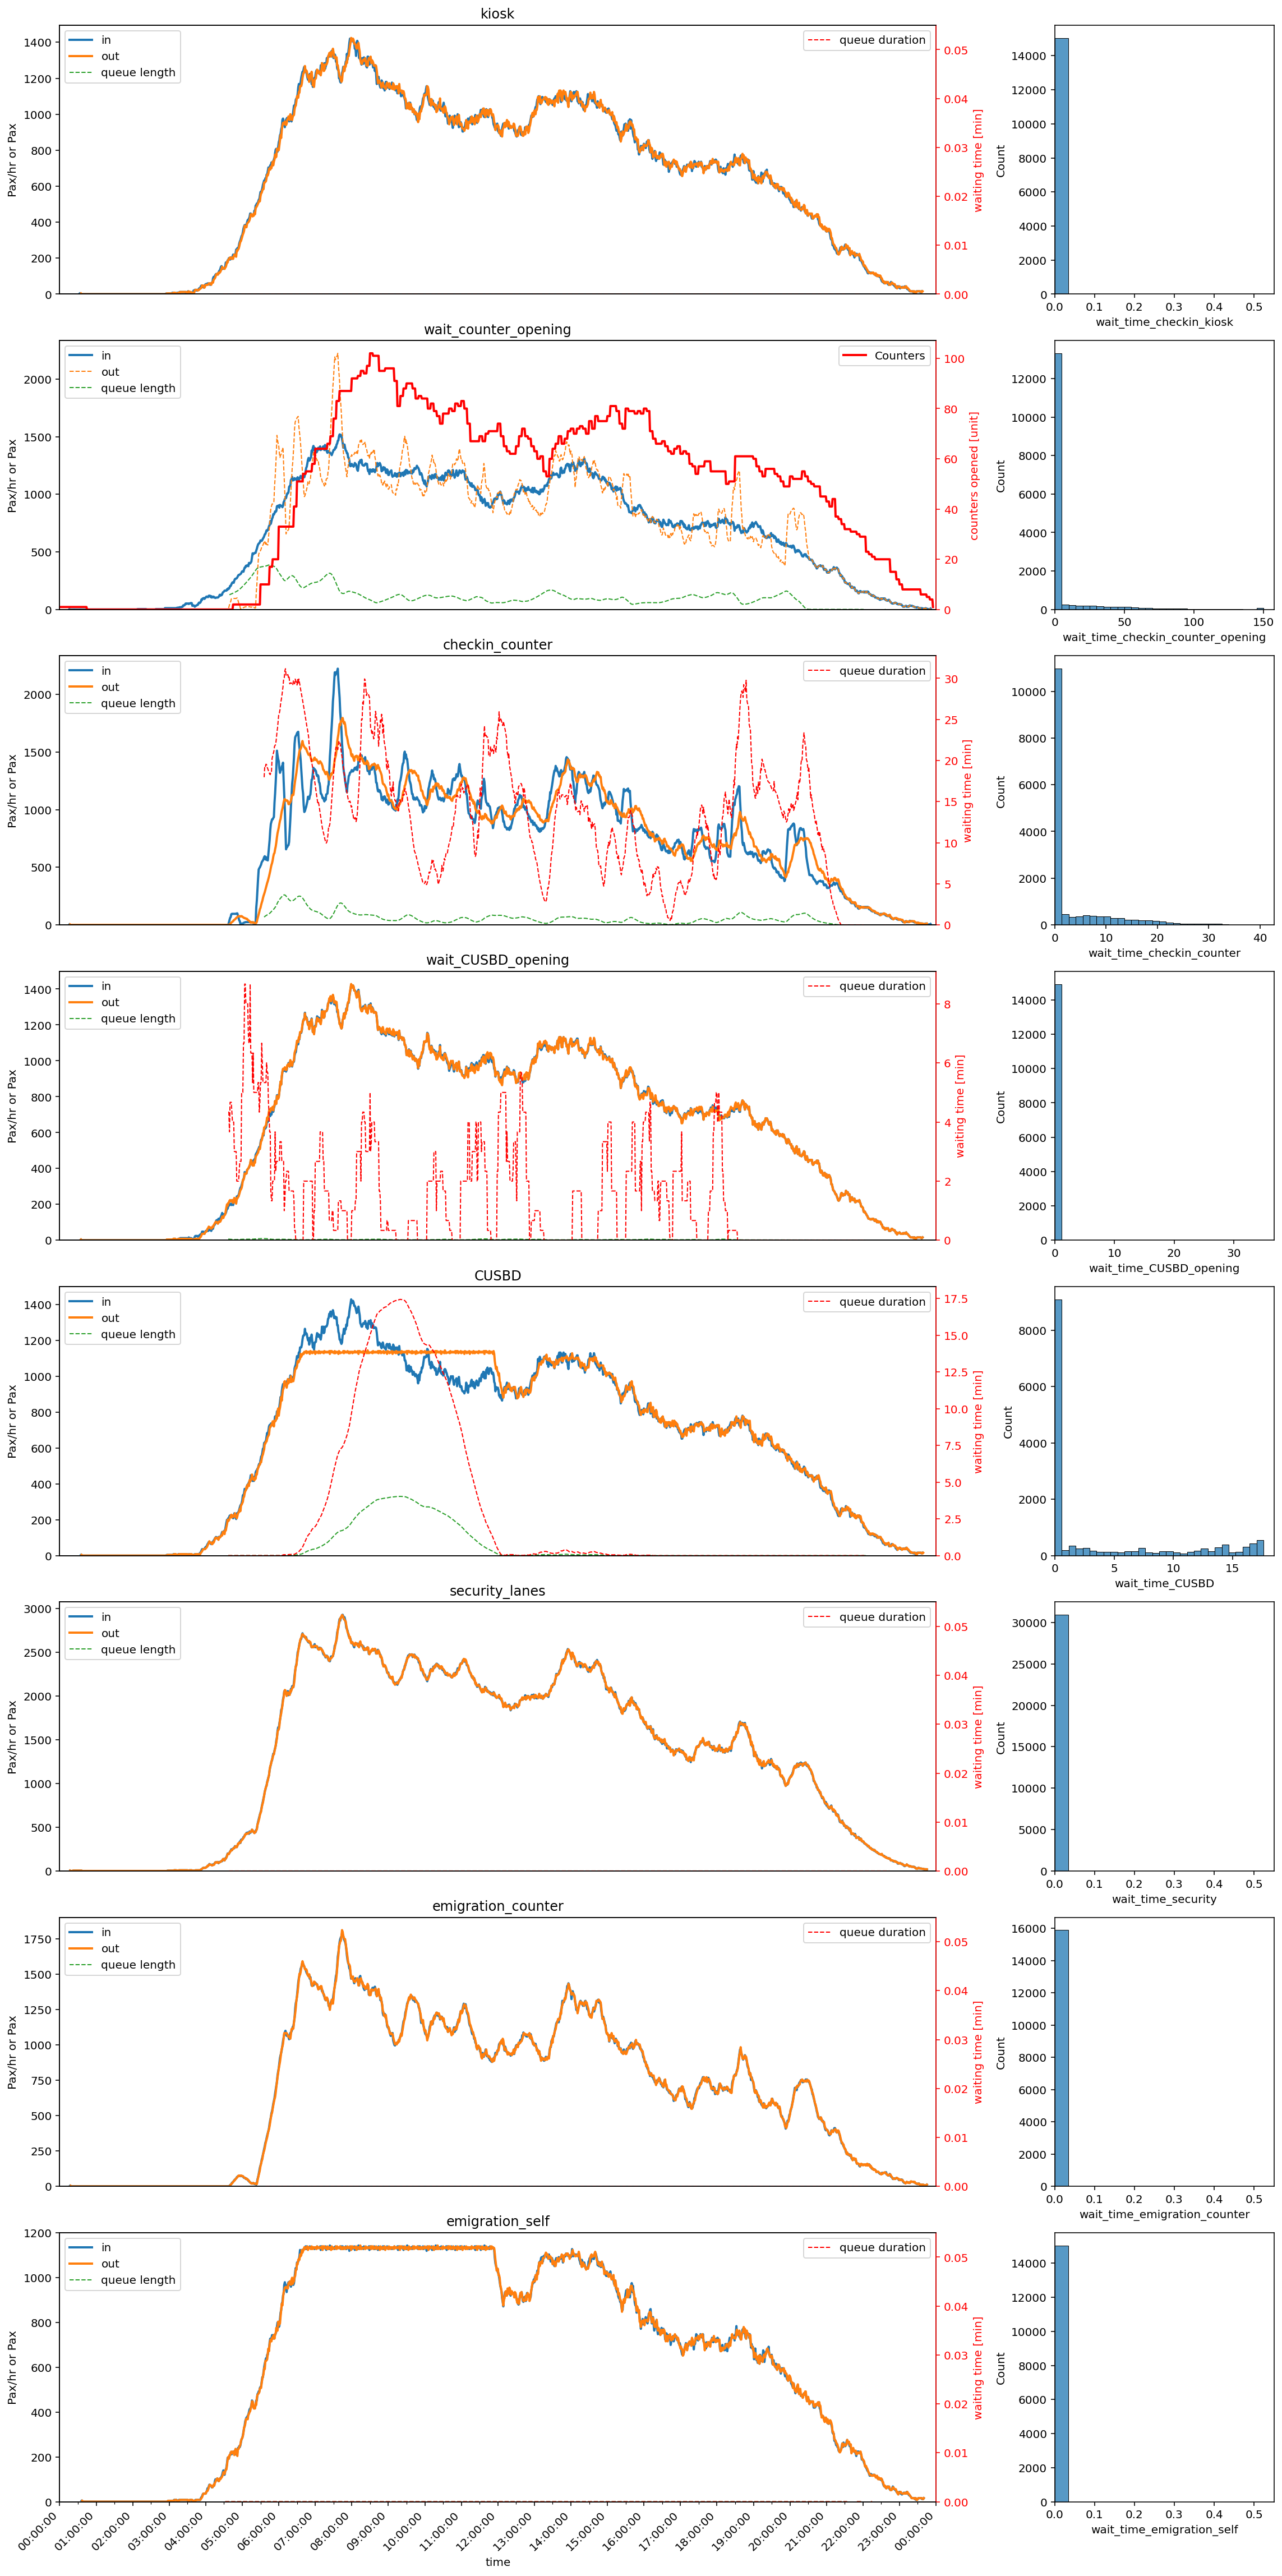

<IPython.core.display.Javascript object>

In [28]:
(
    df_result,
    _,
    dct_hist_wait_time,
    _,
) = KIX_T1d_CUSBD(**dct_run_param_T1d_2025)

In [34]:
a,b=calculate_EBS_modern_pax_only(df_result)

<IPython.core.display.Javascript object>

In [35]:
a

1202.0

<IPython.core.display.Javascript object>